### For the comparison of different methods under multidimensional commutative noise. 
We introduce high resolution as the truth, and the order should be strong order 1/2. 

In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "true"
import sys
sys.path.append('..')
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax import config
from jax import vmap
import time

config.update("jax_enable_x64", True)
import scienceplots
plt.style.use(['science','ieee'])

Next, we update the method to have 256 spatial resolution, as to mimimise spatial errors.
We choose $dt = (10^{-5}) i$, for $i=1,...,1/16$. $T_{max} = 0.1$. 

In [2]:
key1 = jax.random.PRNGKey(0)
i=8
nmax = int(4000 * 2**i) #10000
tmax = 4.0 # 0.1 timestep
dt = 0.001*(1/2)**i # tmax/nmax
E=1; P=3
dW = jax.random.normal(key1, shape=(nmax, E, P))
dW_refine = []; W_refine = []; time_refine = []
for l in range(0, i+1):
    nmax = int(4000 * 2**(l))# the initial one is at lowest resolution 
    time_refine.append( jnp.linspace(0, tmax, nmax) )
    dW_refine.append(dW)
    W_refine.append(jnp.cumsum(dW, axis=0))
    dW = (dW + jnp.roll(dW, -1, axis=0))[::2, :, :]
dW_refine.reverse()
W_refine.reverse()
#time_refine.reverse()
print(nmax,len(time_refine[0]),len(W_refine[0]))
print(len(time_refine[-1]),len(W_refine[-1]))

final_save = []

@jax.jit
def relative_error_final(signal_final, analytic_final):
    return jnp.linalg.norm(signal_final-analytic_final)/jnp.linalg.norm(analytic_final)

array = jnp.zeros(8)
key = jax.random.PRNGKey(0)
for i in range(8):
    print(i)
    signal_params = ConfigDict(KDV_params_2_SALT)
    signal_params.update(E=1,method='Dealiased_SETDRK4',dt = 0.001*(1/2)**i, nt = int(4000 * 2**i) ,tmax=4.0,nx=256,P=3,S=0,noise_magnitude=0.01,Advection_basis_name='compact_bump')
    signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
    #signal_model.params.update(E=1,method='Dealiased_SETDRK4',dt = 0.001*(1/2)**i, nt = int(4000 * 2**i) ,tmax=4.0,nx=256,P=3,S=0,noise_magnitude=0.01,Advection_basis_name='compact_bump')
    initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
    dW = (dW_refine[i]/jnp.sqrt(2**(8-i))) # renormalise. from the refined dW created.
    signal_final = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key) #the final input is scan length? 
    final_save.append(signal_final)
for i in range(8):
    array = array.at[i].set(relative_error_final( final_save[i],final_save[-1]))
print(array)



1024000 4000 4000
1024000 1024000
0
1
2
3
4
5
6
7
[0.12906697 0.0240313  0.00643164 0.00766077 0.00103182 0.0007984
 0.00085749 0.        ]


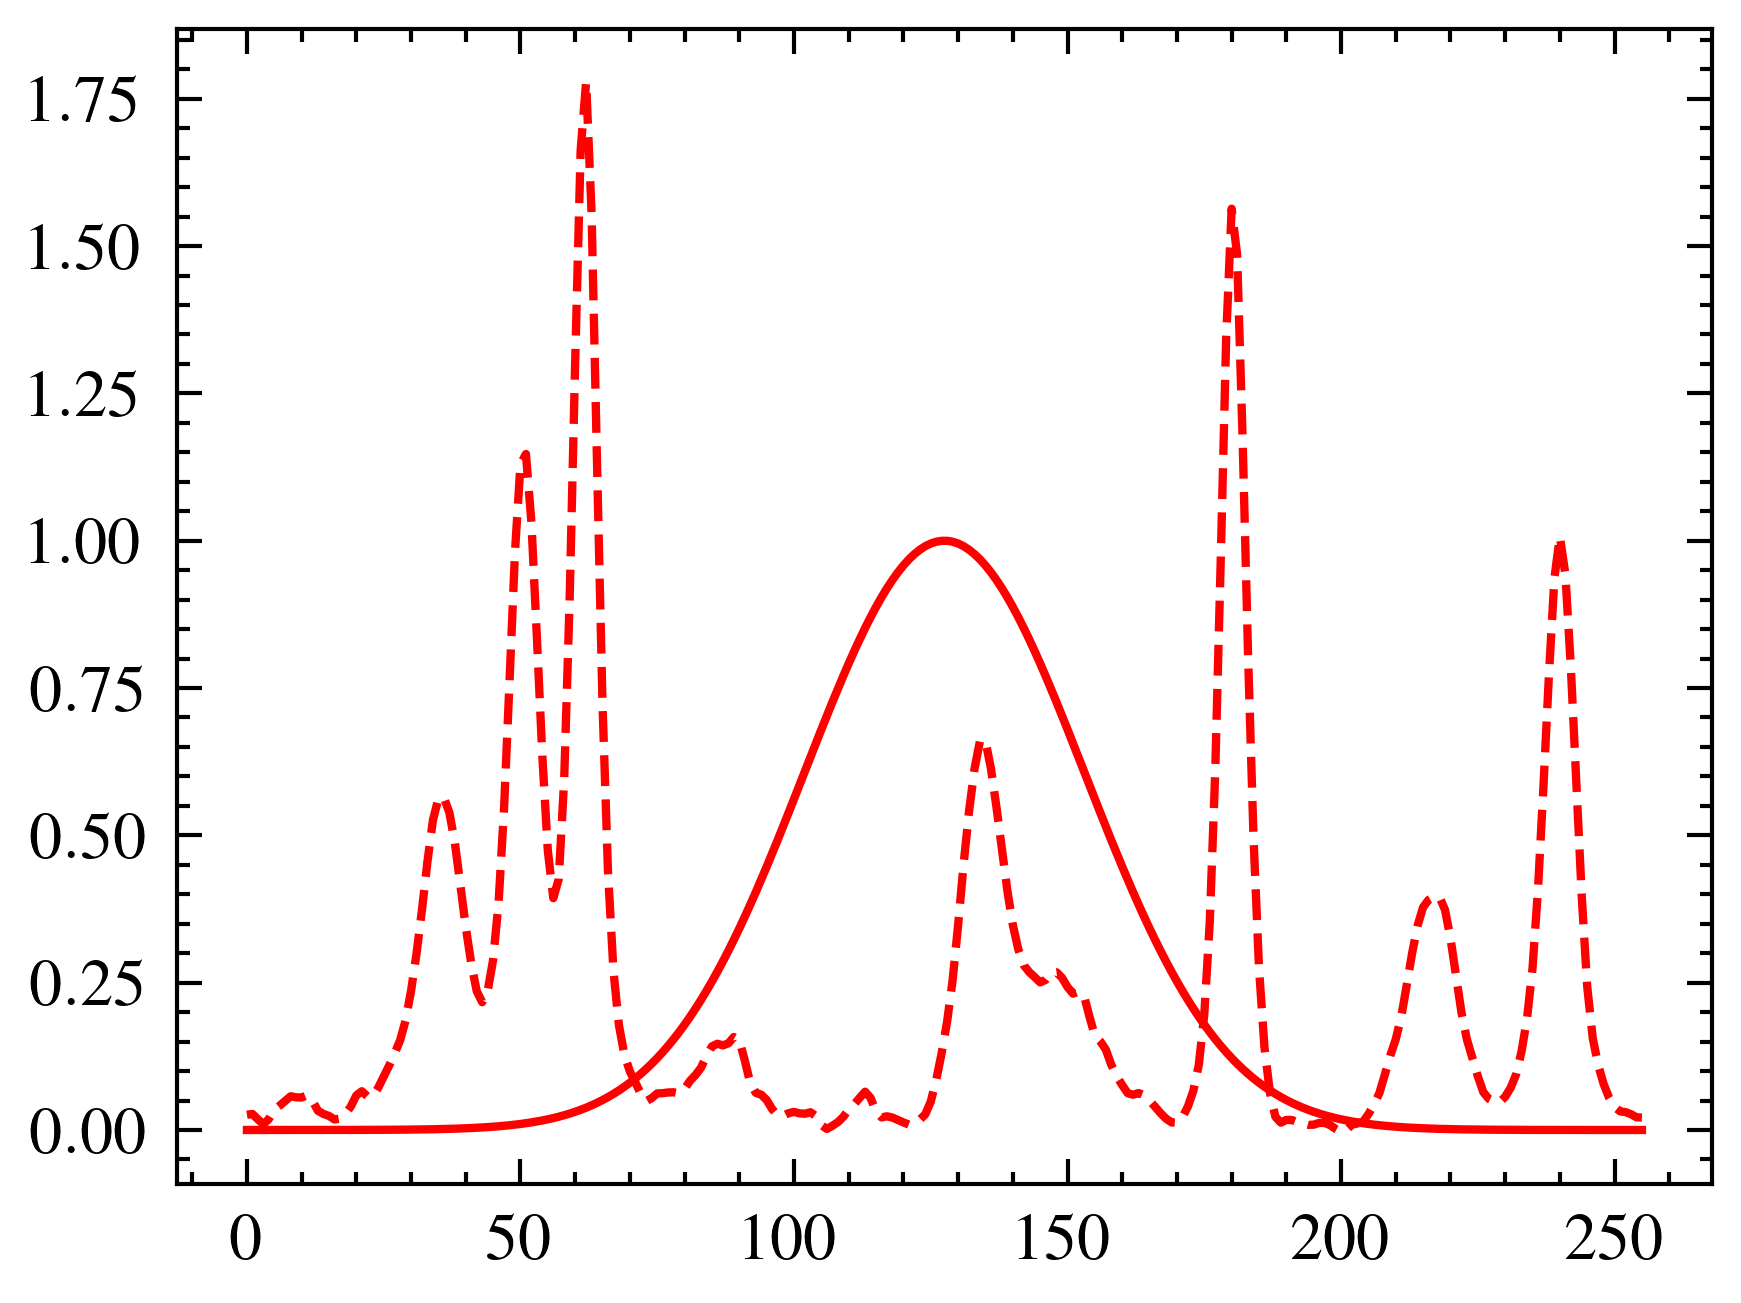

In [3]:
plt.plot(initial_signal[-1],c='r')
plt.plot(signal_final[-1])
plt.show()

0.0036778890990994094


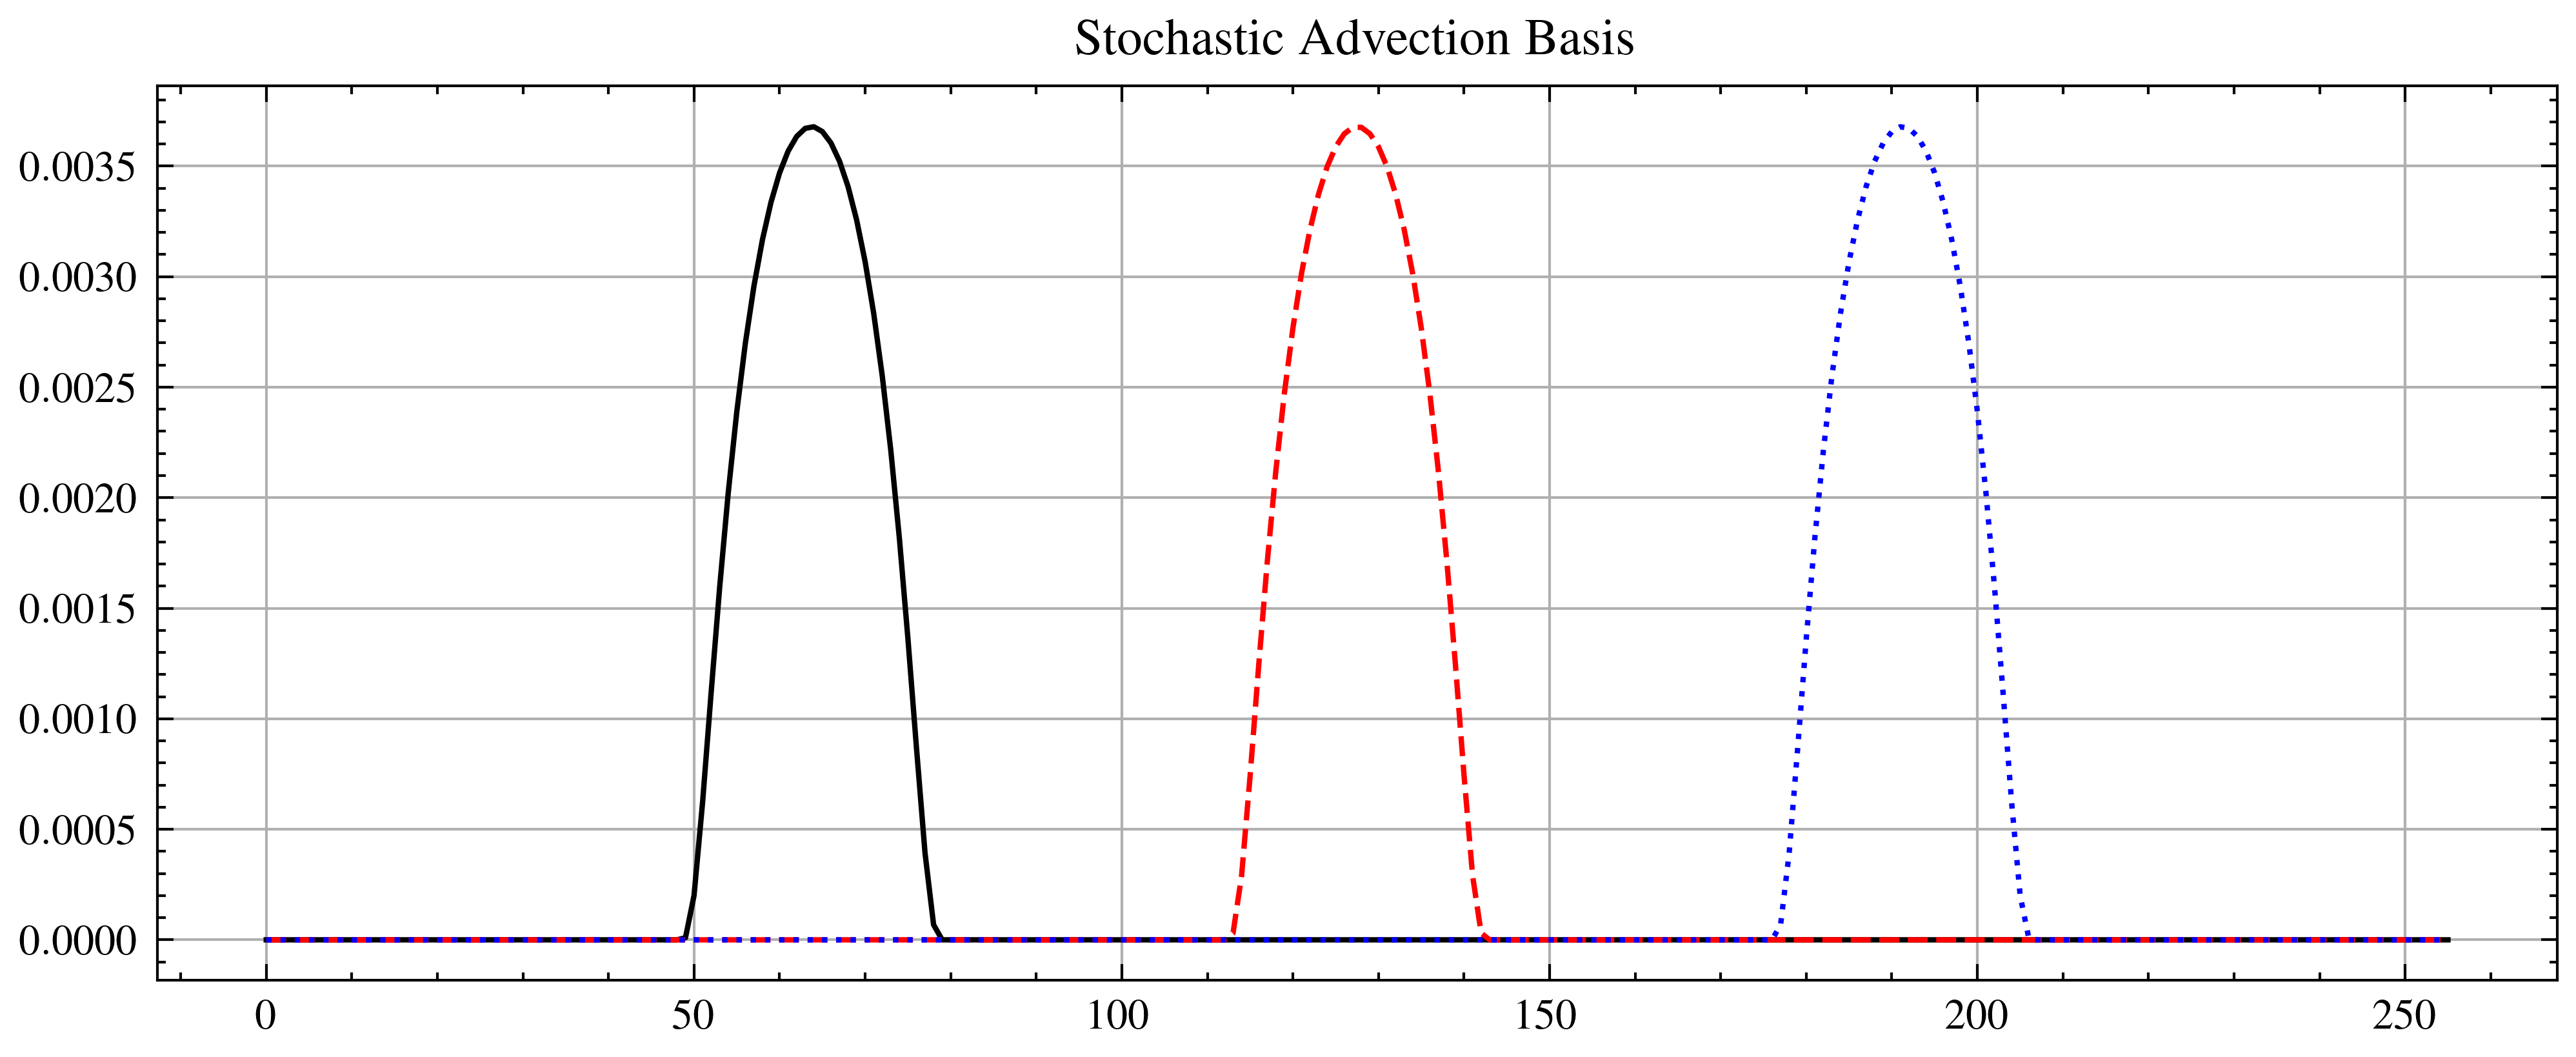

In [4]:
base = signal_model.stochastic_advection_basis
print(jnp.amax(base))
plt.figure(figsize=(8, 3))
plt.plot(base[:,:].T)
plt.title("Stochastic Advection Basis")
plt.grid(True)
plt.savefig('../Saving/Example_5_G_COM_TC/EX5_G_COM_commutative.png',bbox_inches='tight',dpi=300)
plt.show()

[0.12906697 0.0240313  0.00643164 0.00766077 0.00103182 0.0007984
 0.00085749 0.        ] (8,)


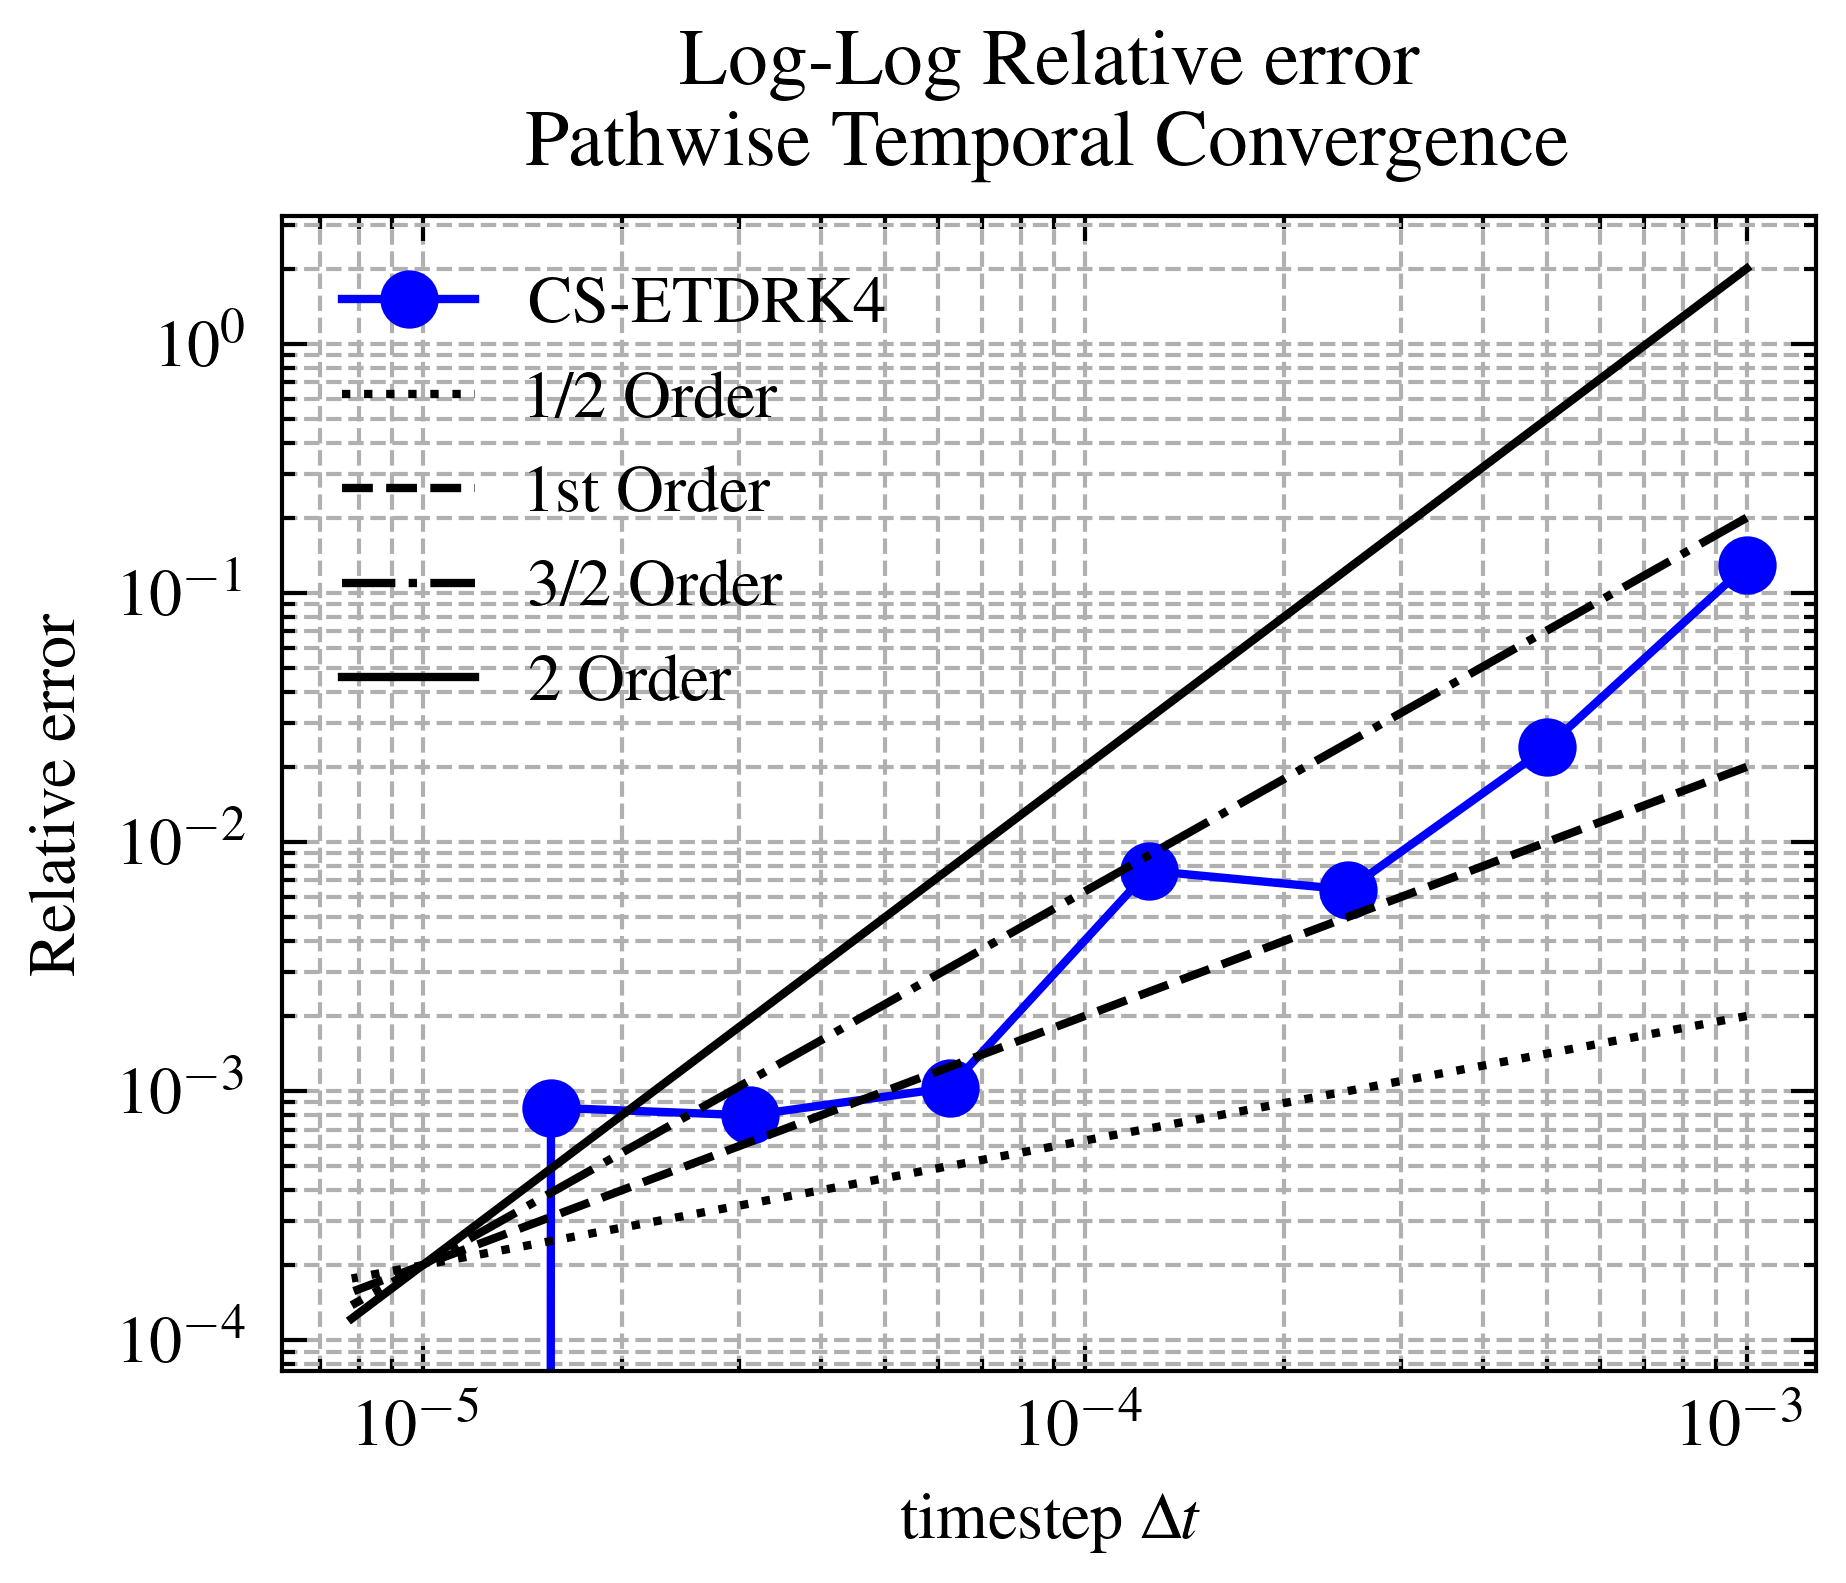

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
dt = 0.001*np.asarray([1.,1/2,1/4,1/8,1/16,1/32,1/64,1/128])
values = array
print(values,values.shape)
a = 1e-5
v=0.0002
plt.figure()
plt.loglog(dt,values, marker='o', linestyle='-', color='b',label='CS-ETDRK4')

plt.loglog(dt,(dt**0.5)/a**0.5*v, linestyle=':', color='k', label=r'1/2 Order')
plt.loglog(dt,dt/a*v, linestyle='--', color='k', label='1st Order')
plt.loglog(dt,(dt**1.5)/a**1.5*v, linestyle='-.', color='k', label='3/2 Order')
plt.loglog(dt,dt**2/a**2*v, linestyle='-', color='k', label='2 Order')

plt.xlabel(r'timestep $\Delta t$')
plt.ylabel('Relative error')
plt.title('Log-Log Relative error \n Pathwise Temporal Convergence')
plt.grid(True, which="both", ls="--")
plt.legend()
#plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/Temporal_convergence_2.png',bbox_inches='tight',dpi=300)
plt.show()

I want to have smaller and larger 

previously 
max_number = 10
array = jnp.zeros([len(methods),max_number])
total_array = jnp.zeros([9,max_number])
key = jax.random.PRNGKey(0)
nmax = int(4000 * 2**max_number)# highest resolution is 100 2^{16} timestes
tmax = 4.0
dt = 0.001*(1/2)**max_number # 1e^{-3}

I am going to change to 
max_number = 14 2*2*2*2 = 16 times larger for the final timestep but 10 times smaller because we start with bigger dt
array = jnp.zeros([len(methods),max_number])
total_array = jnp.zeros([9,max_number])
key = jax.random.PRNGKey(0)
nmax = int(400 * 2**max_number)# highest resolution is 100 2^{16} timestes
tmax = 4.0
dt = 0.01*(1/2)**max_number # 1e^{-3}

In [6]:
methods = ['Dealiased_SETDRK4','Dealiased_IFSRK4','Dealiased_SRK4']
max_number = 16
array = jnp.zeros([len(methods),max_number])
total_array = jnp.zeros([9,max_number])
key = jax.random.PRNGKey(0)
nmax = int(400 * 2**max_number)# highest resolution is 100 2^{16} timestes
tmax = 4.0
dt = 0.01*(1/2)**max_number # 1e^{-3}
assert dt*nmax == tmax, "dt*nmax must equal tmax for the setup to be correct."
E=1; P=3
dW = jax.random.normal(key, shape=(nmax, E, P))

@jax.jit
def relative_error_final(a,b):
    return jnp.linalg.norm(a-b)/jnp.linalg.norm(b)

dW_refine = []; W_refine = []; time_refine = []
for l in range(0,max_number+1):
    nmax = int(400 * 2**(l))# the initial one is at lowest resolution 
    time_refine.append( jnp.linspace(0, tmax, nmax) )
    dW_refine.append(dW)
    W_refine.append(jnp.cumsum(dW, axis=0))
    dW = (dW + jnp.roll(dW, -1, axis=0))[::2, :, :]
dW_refine.reverse()
W_refine.reverse()

signal_params = ConfigDict(KDV_params_2_SALT)
signal_params.update(E=1,method='Dealiased_SETDRK4',dt= 0.01*(1/2)**max_number, nt = int(400 * 2**max_number),tmax=4.0,nx=256,P=3,S=0,noise_magnitude=0.01,Advection_basis_name='compact_bump')
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
dW =(dW_refine[max_number]/jnp.sqrt(2**(max_number-max_number)))
analytic_final = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key) #the final input is scan length? 
del signal_model
print("analytic done")
print(analytic_final.shape)
print(analytic_final[0,:].shape)
ans = relative_error_final(analytic_final[0,:], analytic_final[0,:])
print(ans)
for j, method in enumerate(methods):
    for i in range(max_number):
        print(i,method)
        signal_params = ConfigDict(KDV_params_2_SALT)
        signal_params.update(E=1,method=method,dt = 0.01*(1/2)**i, nt = int(400 * 2**i) ,tmax=4.0,nx=256,P=3,S=0,noise_magnitude=0.01,Advection_basis_name='compact_bump')
        signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
        initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
        dW =(dW_refine[i]/jnp.sqrt(2**(max_number-i))) # renormalise. from the refined dW created.
        signal_final = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key) #the final input is scan length? 
        # plt.plot(signal_final[0,:], label=f'{method} {i}')
        # plt.plot(analytic_final[0,:], label='Analytic',c='r')
        # plt.show()
        ans = relative_error_final(signal_final[0,:], analytic_final[0,:])
        print("relative error",ans)
        array = array.at[j,i].set(ans)
        del signal_model
        del signal_params
        print("done",j,i,method)
for j in range(len(methods)):
    total_array = total_array.at[j,:].set(array[j,:])

analytic done
(1, 256)
(256,)
0.0
0 Dealiased_SETDRK4
relative error nan
done 0 0 Dealiased_SETDRK4
1 Dealiased_SETDRK4
relative error 0.9624790808131815
done 0 1 Dealiased_SETDRK4
2 Dealiased_SETDRK4
relative error 0.8947463192834827
done 0 2 Dealiased_SETDRK4
3 Dealiased_SETDRK4
relative error 0.08996007590795721
done 0 3 Dealiased_SETDRK4
4 Dealiased_SETDRK4
relative error 0.011940530247432878
done 0 4 Dealiased_SETDRK4
5 Dealiased_SETDRK4
relative error 0.008449825529581938
done 0 5 Dealiased_SETDRK4
6 Dealiased_SETDRK4
relative error 0.002920257271890579
done 0 6 Dealiased_SETDRK4
7 Dealiased_SETDRK4
relative error 0.0013308627225606692
done 0 7 Dealiased_SETDRK4
8 Dealiased_SETDRK4
relative error 0.0005644693486416555
done 0 8 Dealiased_SETDRK4
9 Dealiased_SETDRK4
relative error 0.00031052271864384477
done 0 9 Dealiased_SETDRK4
10 Dealiased_SETDRK4
relative error 0.00023410220802406868
done 0 10 Dealiased_SETDRK4
11 Dealiased_SETDRK4
relative error 8.818866430551322e-05
done 0 11

[[           nan 9.62479081e-01 8.94746319e-01 8.99600759e-02
  1.19405302e-02 8.44982553e-03 2.92025727e-03 1.33086272e-03
  5.64469349e-04 3.10522719e-04 2.34102208e-04 8.81886643e-05
  4.75500036e-05 5.51795729e-06 7.37337979e-06 3.12678217e-06]
 [           nan            nan 9.35831218e-01 6.16321443e-01
  2.68561214e-02 8.58908251e-03 2.92140570e-03 1.33123016e-03
  5.64485262e-04 3.10523143e-04 2.34102192e-04 8.81887051e-05
  4.75500005e-05 5.51795545e-06 7.37334708e-06 3.12698321e-06]
 [           nan            nan            nan            nan
             nan            nan 3.54924919e-03 1.34325353e-03
  5.64343214e-04 3.10521132e-04 2.34101599e-04 8.81886482e-05
  4.75500661e-05 5.51788818e-06 7.37501239e-06 3.12552673e-06]]
(3, 16)
[[           nan 9.62479081e-01 8.94746319e-01 8.99600759e-02
  1.19405302e-02 8.44982553e-03 2.92025727e-03 1.33086272e-03
  5.64469349e-04 3.10522719e-04 2.34102208e-04 8.81886643e-05
  4.75500036e-05 5.51795729e-06 7.37337979e-06 3.12678217e

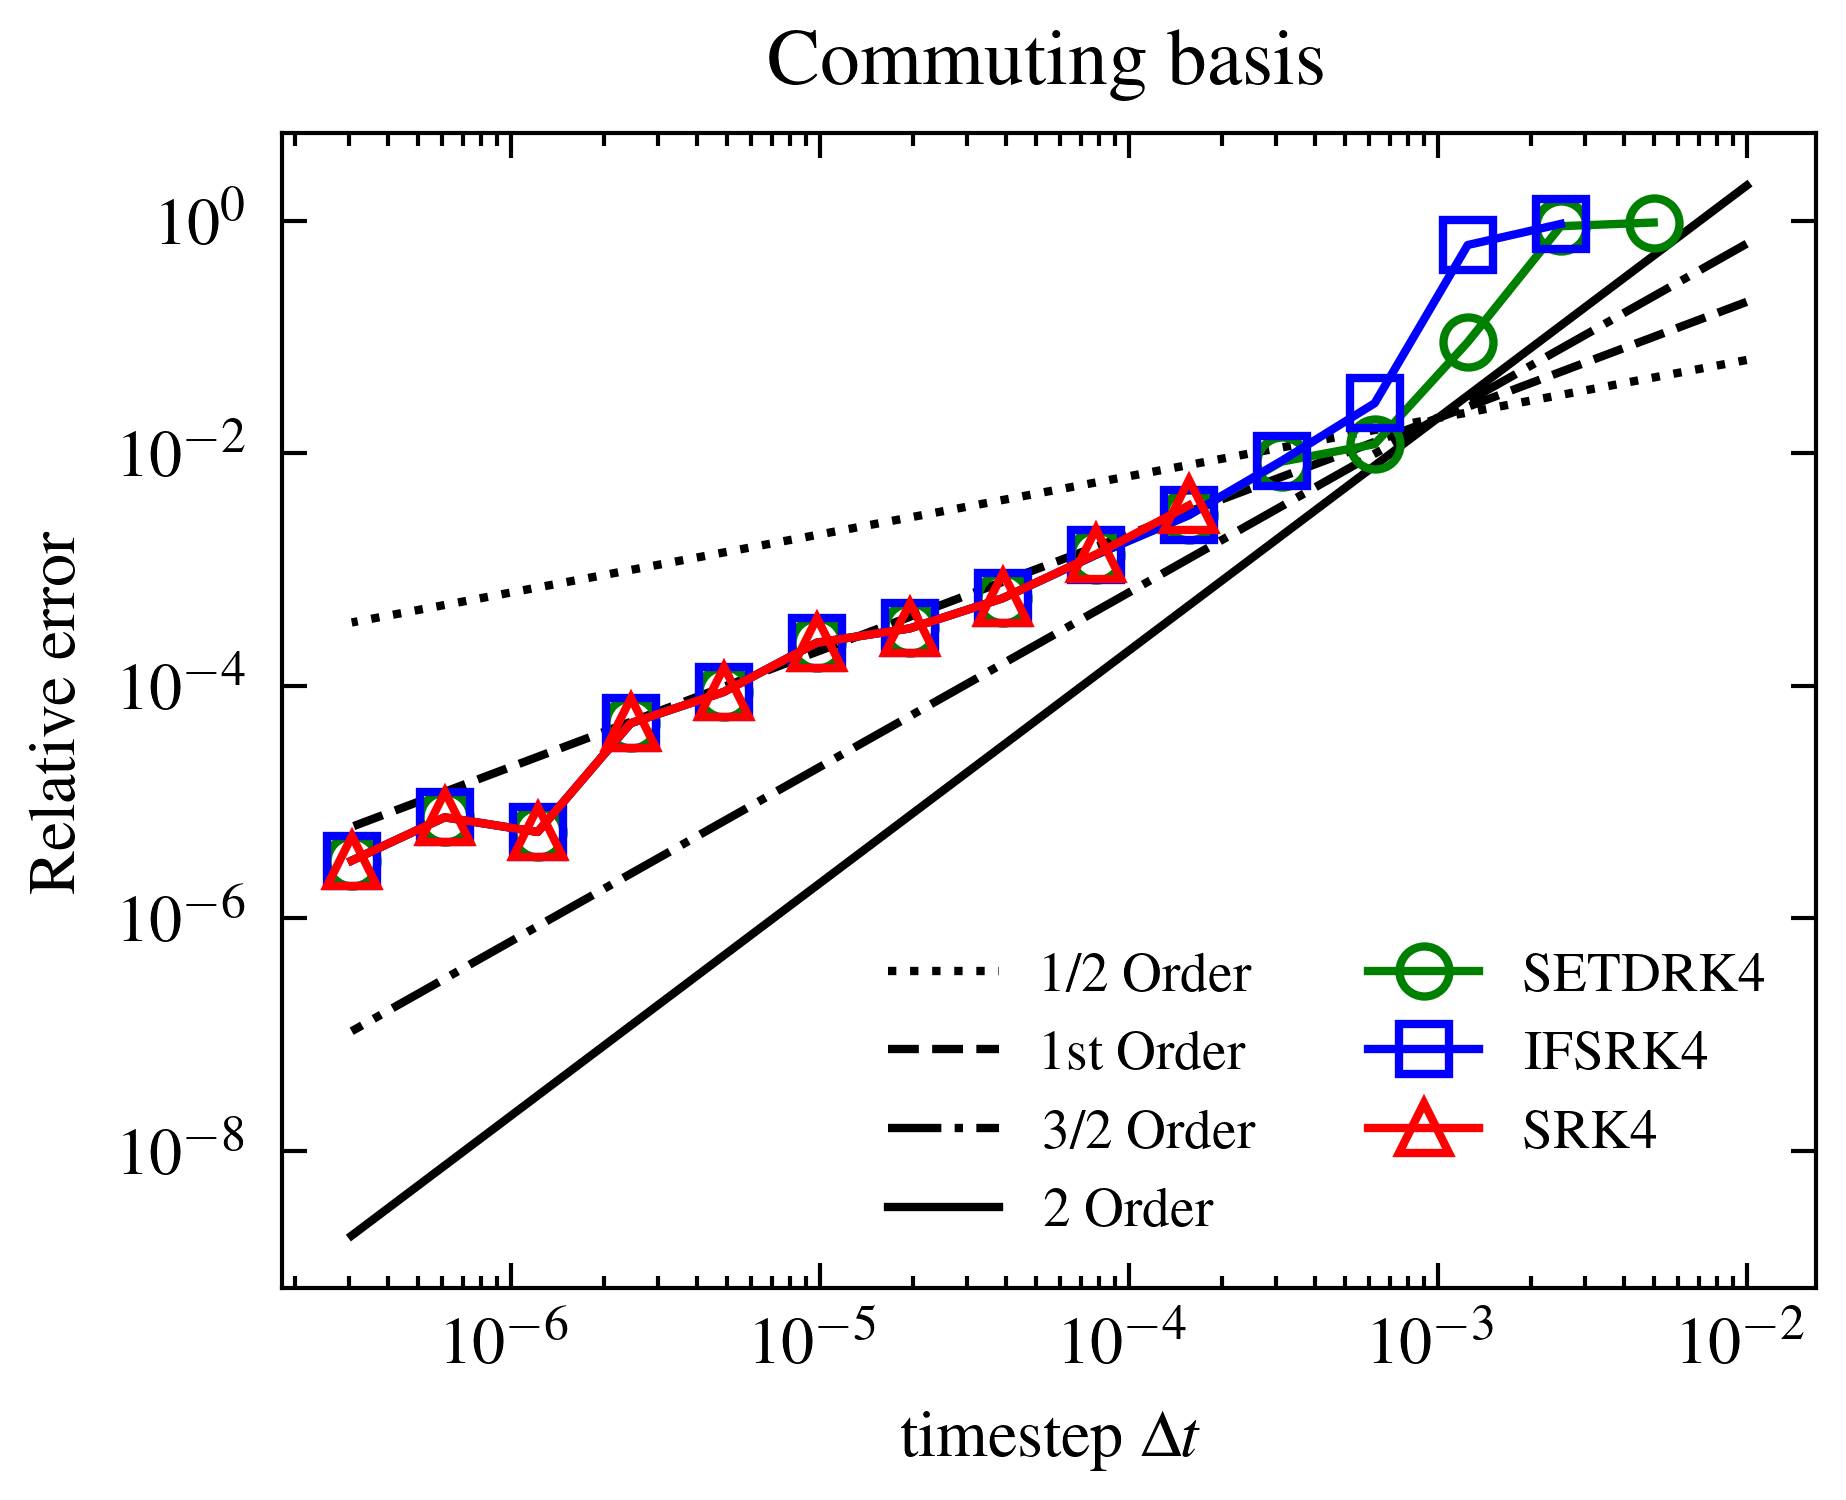

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
# dt = 0.001*np.asarray([1.,1/2,1/4,1/8,1/16,1/32,1/64,1/128,1/256,1/512])
dt = 0.01*np.asarray([2**-k for k in range(max_number)])
methods = ['Dealiased_SETDRK4', 'Dealiased_IFSRK4','Dealiased_SRK4']
values = array
print(values)
print(values.shape)
values = array
print(values,values.shape)
a = 1e-3
v= 0.02
plt.figure()
#plt.scatter(a,0.1, color='r', label='point')
# Mask values greater than 1 before plotting
values = np.where(values > 2, np.nan, values)
plt.loglog(dt,(dt**0.5)/a**0.5*v, linestyle=':', color='k', label=r'1/2 Order')
plt.loglog(dt,dt/a*v, linestyle='--', color='k', label='1st Order')
plt.loglog(dt,(dt**1.5)/a**1.5*v, linestyle='-.', color='k', label='3/2 Order')
plt.loglog(dt,dt**2/a**2*v, linestyle='-', color='k', label='2 Order')
marker_list = ['o', 's', '^', 'D', 'v', 'x', '+', '*', 'p', 'H', 'd', 'X']
color_list = ['g', 'b', 'r', 'c', 'm', 'y']
# In matplotlib, the marker for an upward-pointing triangle is '^'
for j, method in enumerate(methods):
    marker = marker_list[j % len(marker_list)]
    color = color_list[j % len(color_list)]
    plt.loglog(dt, total_array[j, :], marker=marker,color=color, linestyle='-', label=f'{method.replace("Dealiased_", "")}', markerfacecolor='none')

# for j,method in enumerate(methods):
#     plt.loglog(dt,values[j,:], marker='o', linestyle='-',label=f'{method}')
# Highlight 4th order convergence for SETDRK4 near first non-nan values
# setdrk_idx = methods.index('Dealiased_SETDRK4')
# setdrk_values = values[setdrk_idx]
# # Find the first non-nan index
# first_valid = np.where(~np.isnan(setdrk_values))[0][0]
# # Select a window of points (e.g., 4 points) for the fit
# window = 2
# idxs = np.arange(first_valid, min(first_valid + window, len(setdrk_values)))
# x_fit = dt[idxs]
# y_fit = setdrk_values[idxs]

# # Fit a line in log-log space (slope should be close to 4 for 4th order)
# coeffs = np.polyfit(np.log(x_fit), np.log(y_fit), 1)
# print(f"Fitted coefficients for SETDRK4: {coeffs}")
# y_fit_line = np.exp(np.polyval(coeffs, np.log(x_fit)))
# plt.loglog(x_fit, y_fit_line, 'k--', linewidth=2, label=f'O({coeffs[0]:.3g}) Order Fit (SETDRK4)')

plt.xlabel(r'timestep $\Delta t$')
plt.ylabel('Relative error')
plt.title('Commuting basis')
#plt.grid(True, which="both", ls="--")
plt.legend()
plt.legend(fontsize='small', loc='best', ncol=2)
#plt.grid(True, which="both", ls="--")
plt.savefig('../Saving/Example_5_G_COM_TC/EX5_G_COM_Temporal_convergence_RK4_IFRK4_ETDRK4.png',bbox_inches='tight',dpi=300)
plt.show()

In [8]:
methods = ['Dealiased_eSSPIFSRK_P_33','Dealiased_SETDRK33','Dealiased_SSP33']
max_number = 16
array = jnp.zeros([len(methods),max_number])
key = jax.random.PRNGKey(0)
nmax = int(400 * 2**max_number)# highest resolution is 100 2^{16} timestes
tmax = 4.0
dt = 0.01*(1/2)**max_number
assert dt*nmax == tmax, "dt*nmax must equal tmax for the setup to be correct."
E=1; P=3
dW = jax.random.normal(key, shape=(nmax, E, P))

@jax.jit
def relative_error_final(a,b):
    return jnp.linalg.norm(a-b)/jnp.linalg.norm(b)

dW_refine = []; W_refine = []; time_refine = []
for l in range(0,max_number+1):
    nmax = int(400 * 2**(l))# the initial one is at lowest resolution 
    time_refine.append( jnp.linspace(0, tmax, nmax) )
    dW_refine.append(dW)
    W_refine.append(jnp.cumsum(dW, axis=0))
    dW = (dW + jnp.roll(dW, -1, axis=0))[::2, :, :]
dW_refine.reverse()
W_refine.reverse()

signal_params = ConfigDict(KDV_params_2_SALT)
signal_params.update(E=1,method='Dealiased_SETDRK4',dt= 0.01*(1/2)**max_number, nt = int(400 * 2**max_number),tmax=4.0,nx=256,P=3,S=0,noise_magnitude=0.01,Advection_basis_name='compact_bump')
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
dW =(dW_refine[max_number]/jnp.sqrt(2**(max_number-max_number)))
analytic_final = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key) #the final input is scan length? 
del signal_model
print("analytic done")
print(analytic_final.shape)
print(analytic_final[0,:].shape)
ans = relative_error_final(analytic_final[0,:], analytic_final[0,:])
print(ans)
for j, method in enumerate(methods):
    for i in range(max_number):
        print(i,method)
        signal_params = ConfigDict(KDV_params_2_SALT)
        signal_params.update(E=1,method=method,dt = 0.01*(1/2)**i, nt = int(400 * 2**i) ,tmax=4.0,nx=256,P=3,S=0,noise_magnitude=0.01,Advection_basis_name='compact_bump')
        signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
        initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
        dW =(dW_refine[i]/jnp.sqrt(2**(max_number-i))) # renormalise. from the refined dW created.
        signal_final = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key) #the final input is scan length? 
        # plt.plot(signal_final[0,:], label=f'{method} {i}')
        # plt.plot(analytic_final[0,:], label='Analytic',c='r')
        # plt.show()
        ans = relative_error_final(signal_final[0,:], analytic_final[0,:])
        print("relative error",ans)
        array = array.at[j,i].set(ans)
        del signal_model
        del signal_params
        print("done",j,i,method)

for j in range(len(methods)):
    total_array = total_array.at[j+3,:].set(array[j,:])

analytic done
(1, 256)
(256,)
0.0
0 Dealiased_eSSPIFSRK_P_33
relative error nan
done 0 0 Dealiased_eSSPIFSRK_P_33
1 Dealiased_eSSPIFSRK_P_33
relative error nan
done 0 1 Dealiased_eSSPIFSRK_P_33
2 Dealiased_eSSPIFSRK_P_33
relative error 2.395107481403423
done 0 2 Dealiased_eSSPIFSRK_P_33
3 Dealiased_eSSPIFSRK_P_33
relative error 0.9307154758643061
done 0 3 Dealiased_eSSPIFSRK_P_33
4 Dealiased_eSSPIFSRK_P_33
relative error 0.6413699984937937
done 0 4 Dealiased_eSSPIFSRK_P_33
5 Dealiased_eSSPIFSRK_P_33
relative error 0.06866880891000107
done 0 5 Dealiased_eSSPIFSRK_P_33
6 Dealiased_eSSPIFSRK_P_33
relative error 0.00895828851097411
done 0 6 Dealiased_eSSPIFSRK_P_33
7 Dealiased_eSSPIFSRK_P_33
relative error 0.002173633871964631
done 0 7 Dealiased_eSSPIFSRK_P_33
8 Dealiased_eSSPIFSRK_P_33
relative error 0.000688692407658669
done 0 8 Dealiased_eSSPIFSRK_P_33
9 Dealiased_eSSPIFSRK_P_33
relative error 0.00032416320745777744
done 0 9 Dealiased_eSSPIFSRK_P_33
10 Dealiased_eSSPIFSRK_P_33
relative 

[[           nan            nan 2.39510748e+00 9.30715476e-01
  6.41369998e-01 6.86688089e-02 8.95828851e-03 2.17363387e-03
  6.88692408e-04 3.24163207e-04 2.35275898e-04 8.80595721e-05
  4.74412276e-05 5.52603792e-06 7.39864134e-06 3.13781816e-06]
 [           nan            nan            nan 9.66882306e-01
  2.99719648e-01 3.75020385e-02 5.45738987e-03 1.75332391e-03
  6.32679275e-04 3.18466905e-04 2.34816667e-04 8.80793433e-05
  4.74602652e-05 5.52498790e-06 7.39165718e-06 3.13101400e-06]
 [           nan            nan            nan            nan
             nan            nan 4.56982570e-03 2.37788878e-03
  7.77594141e-04 3.21375305e-04 2.34337740e-04 8.81478076e-05
  4.75007606e-05 5.52437052e-06 7.39882825e-06 3.13936525e-06]]
(3, 16)
[[           nan            nan 2.39510748e+00 9.30715476e-01
  6.41369998e-01 6.86688089e-02 8.95828851e-03 2.17363387e-03
  6.88692408e-04 3.24163207e-04 2.35275898e-04 8.80595721e-05
  4.74412276e-05 5.52603792e-06 7.39864134e-06 3.13781816e

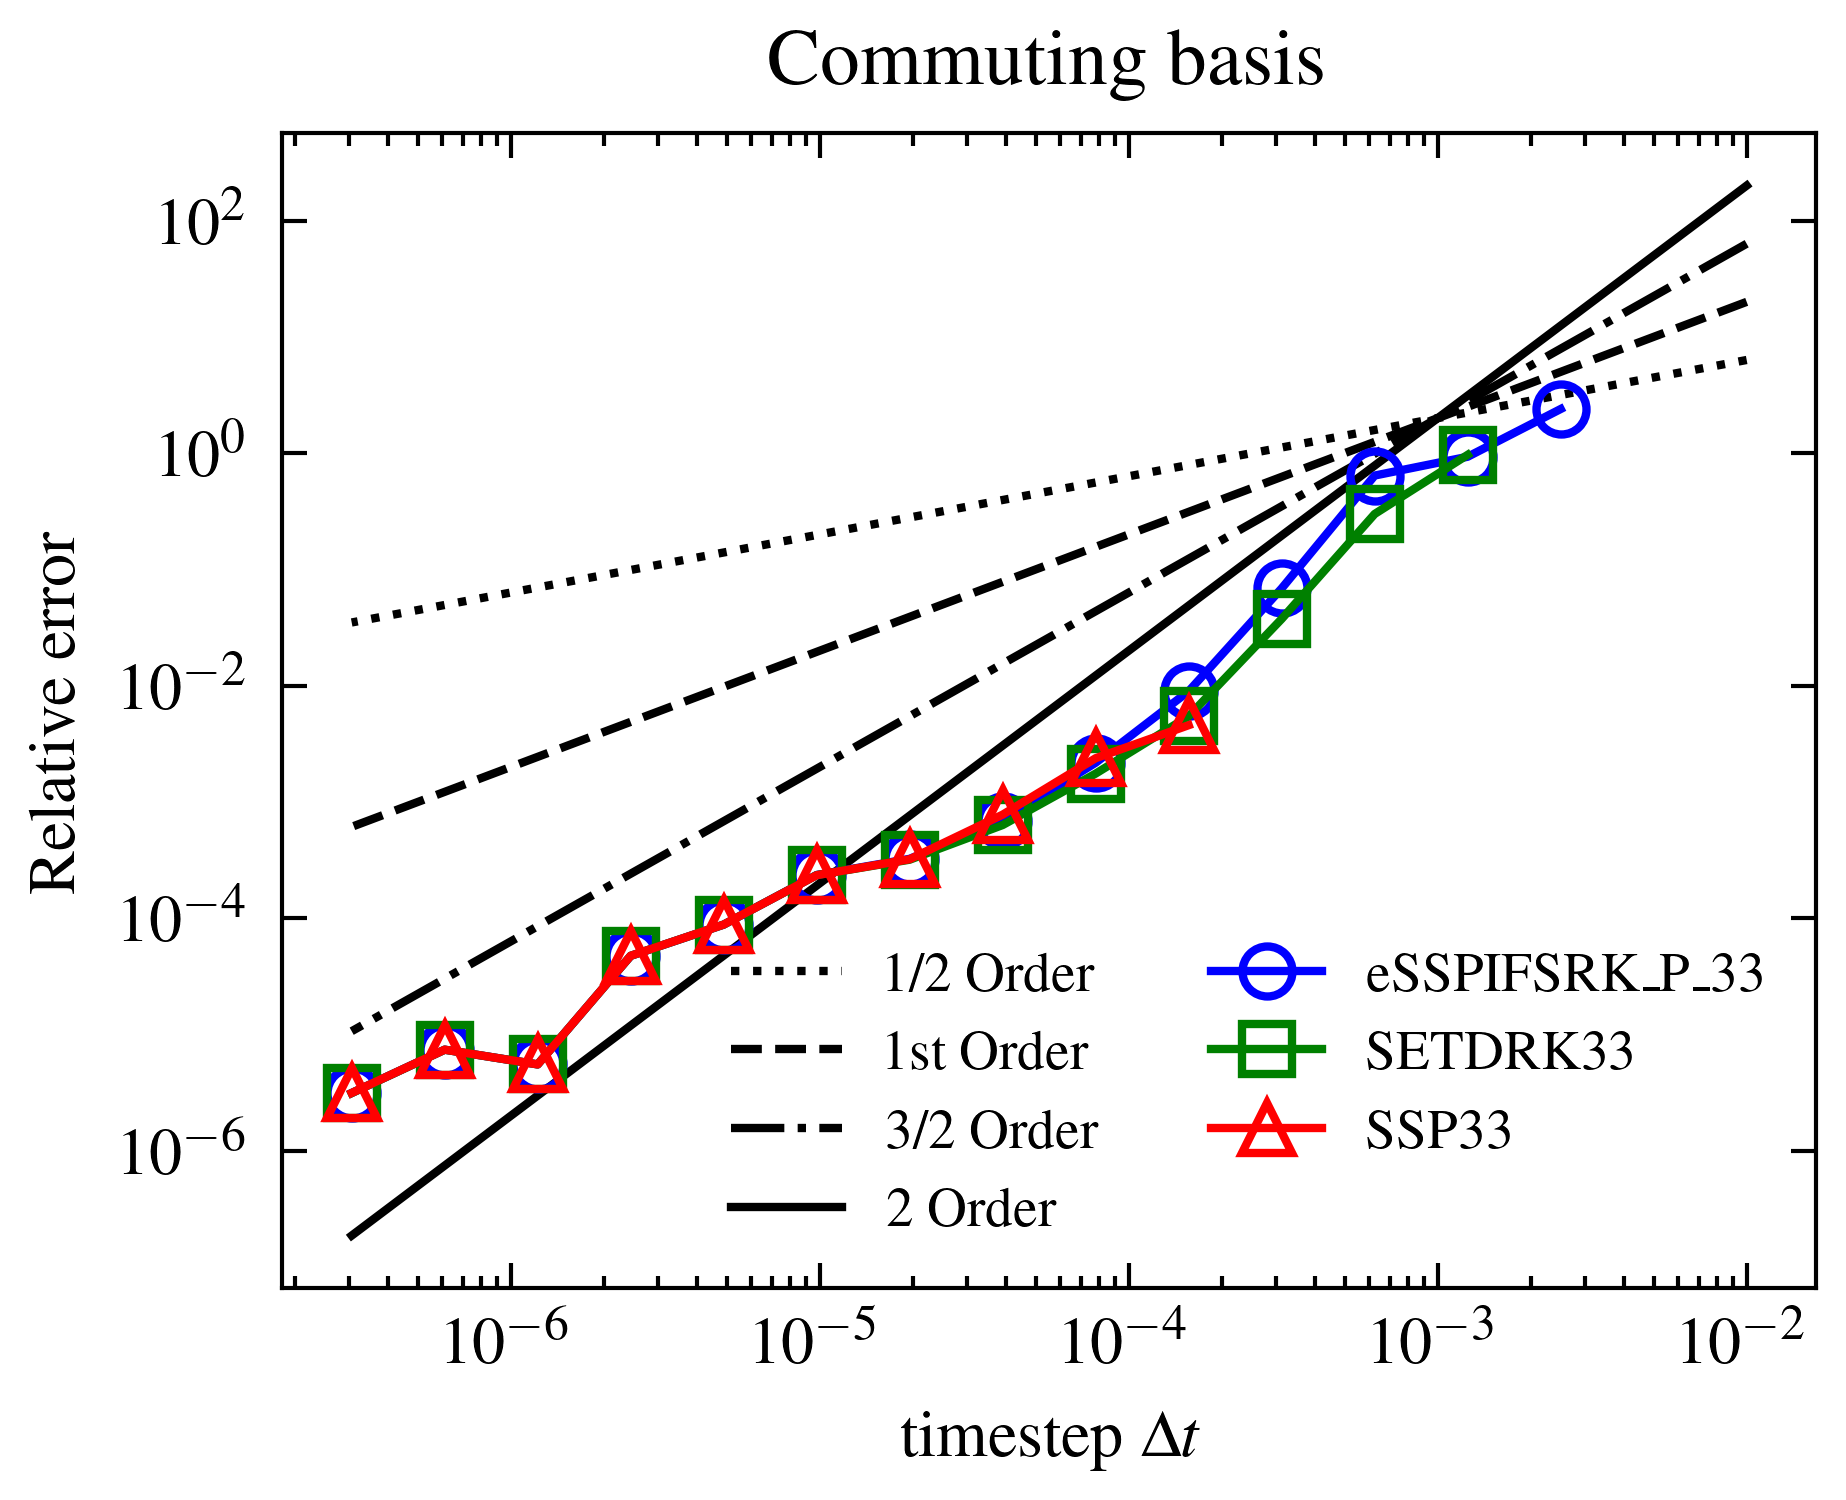

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
dt = 0.01*np.asarray([2**-i for i in range(0,max_number)])
values = array
methods = ['Dealiased_eSSPIFSRK_P_33','Dealiased_SETDRK33','Dealiased_SSP33']

print(values)
print(values.shape)
values = array
print(values,values.shape)
a = 1e-3
v= 2
plt.figure()
#plt.scatter(a,0.1, color='r', label='point')
# Mask values greater than 1 before plotting
values = np.where(values > 1, np.nan, values)
plt.loglog(dt,(dt**0.5)/a**0.5*v, linestyle=':', color='k', label=r'1/2 Order')
plt.loglog(dt,dt/a*v, linestyle='--', color='k', label='1st Order')
plt.loglog(dt,(dt**1.5)/a**1.5*v, linestyle='-.', color='k', label='3/2 Order')
plt.loglog(dt,dt**2/a**2*v, linestyle='-', color='k', label='2 Order')

marker_list = ['o', 's', '^', 'D', 'v', 'x', '+', '*', 'p', 'H', 'd', 'X']
color_list = ['b', 'g', 'r', 'c', 'm', 'y']
# In matplotlib, the marker for an upward-pointing triangle is '^'
for j, method in enumerate(methods):
    marker = marker_list[j % len(marker_list)]
    color = color_list[j % len(color_list)]
    plt.loglog(dt, total_array[j+3, :], marker=marker,color=color, linestyle='-', label=f'{method.replace("Dealiased_", "")}', markerfacecolor='none')

plt.xlabel(r'timestep $\Delta t$')
plt.ylabel('Relative error')
plt.title('Commuting basis')
#plt.grid(True, which="both", ls="--")
plt.legend()
plt.legend(fontsize='small', loc='best', ncol=2)
plt.savefig('../Saving/Example_5_G_COM_TC/EX5_G_COM_Temporal_convergence_SSP33_ETDRK3_eSSPIFSRK_P_33.png',bbox_inches='tight',dpi=300)
plt.show()

In [10]:
methods = ['Dealiased_eSSPIFSRK_P_22','Dealiased_SETDRK22','Dealiased_SSP22']
max_number = 16
array = jnp.zeros([len(methods),max_number])
key = jax.random.PRNGKey(0)
nmax = int(400 * 2**max_number)# highest resolution is 100 2^{16} timestes
tmax = 4.0
dt = 0.01*(1/2)**max_number
assert dt*nmax == tmax, "dt*nmax must equal tmax for the setup to be correct."
E=1; P=3
dW = jax.random.normal(key, shape=(nmax, E, P))

@jax.jit
def relative_error_final(a,b):
    return jnp.linalg.norm(a-b)/jnp.linalg.norm(b)

dW_refine = []; W_refine = []; time_refine = []
for l in range(0,max_number+1):
    nmax = int(400 * 2**(l))# the initial one is at lowest resolution 
    time_refine.append( jnp.linspace(0, tmax, nmax) )
    dW_refine.append(dW)
    W_refine.append(jnp.cumsum(dW, axis=0))
    dW = (dW + jnp.roll(dW, -1, axis=0))[::2, :, :]
dW_refine.reverse()
W_refine.reverse()

signal_params = ConfigDict(KDV_params_2_SALT)
signal_params.update(E=1,method='Dealiased_SETDRK4',dt= 0.01*(1/2)**max_number, nt = int(400 * 2**max_number),tmax=4.0,nx=256,P=3,S=0,noise_magnitude=0.01,Advection_basis_name='compact_bump')
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
dW =(dW_refine[max_number]/jnp.sqrt(2**(max_number-max_number)))
analytic_final = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key) #the final input is scan length? 
del signal_model
print("analytic done")
print(analytic_final.shape)
print(analytic_final[0,:].shape)
ans = relative_error_final(analytic_final[0,:], analytic_final[0,:])
print(ans)
for j, method in enumerate(methods):
    for i in range(max_number):
        print(i,method)
        signal_params = ConfigDict(KDV_params_2_SALT)
        signal_params.update(E=1,method=method,dt = 0.01*(1/2)**i, nt = int(400 * 2**i) ,tmax=4.0,nx=256,P=3,S=0,noise_magnitude=0.01,Advection_basis_name='compact_bump')
        signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
        initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
        dW =(dW_refine[i]/jnp.sqrt(2**(max_number-i))) # renormalise. from the refined dW created.
        signal_final = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key) #the final input is scan length? 
        ans = relative_error_final(signal_final[0,:], analytic_final[0,:])# 0th ensemble member. 
        print("relative error",ans)
        array = array.at[j,i].set(ans)
        del signal_model
        del signal_params
        print("done",j,i,method)
for j in range(len(methods)):
    total_array = total_array.at[j+6,:].set(array[j,:])

analytic done
(1, 256)
(256,)
0.0
0 Dealiased_eSSPIFSRK_P_22
relative error nan
done 0 0 Dealiased_eSSPIFSRK_P_22
1 Dealiased_eSSPIFSRK_P_22
relative error nan
done 0 1 Dealiased_eSSPIFSRK_P_22
2 Dealiased_eSSPIFSRK_P_22
relative error nan
done 0 2 Dealiased_eSSPIFSRK_P_22
3 Dealiased_eSSPIFSRK_P_22
relative error nan
done 0 3 Dealiased_eSSPIFSRK_P_22
4 Dealiased_eSSPIFSRK_P_22
relative error nan
done 0 4 Dealiased_eSSPIFSRK_P_22
5 Dealiased_eSSPIFSRK_P_22
relative error 0.4793449822348793
done 0 5 Dealiased_eSSPIFSRK_P_22
6 Dealiased_eSSPIFSRK_P_22
relative error 0.060438032984387983
done 0 6 Dealiased_eSSPIFSRK_P_22
7 Dealiased_eSSPIFSRK_P_22
relative error 0.008857958289782681
done 0 7 Dealiased_eSSPIFSRK_P_22
8 Dealiased_eSSPIFSRK_P_22
relative error 0.0015962628735702769
done 0 8 Dealiased_eSSPIFSRK_P_22
9 Dealiased_eSSPIFSRK_P_22
relative error 0.00047211158386288273
done 0 9 Dealiased_eSSPIFSRK_P_22
10 Dealiased_eSSPIFSRK_P_22
relative error 0.00029056960513339285
done 0 10 Deal

[[           nan            nan            nan            nan
             nan 4.79344982e-01 6.04380330e-02 8.85795829e-03
  1.59626287e-03 4.72111584e-04 2.90569605e-04 1.14788470e-04
  4.83586242e-05 8.41909272e-06 5.19910158e-06 2.22426683e-06]
 [           nan            nan            nan            nan
  5.83347836e-01 1.24631771e-01 1.97500593e-02 3.96745929e-03
  1.09323040e-03 4.19309204e-04 2.75302169e-04 1.08401587e-04
  4.77918435e-05 7.74551595e-06 5.57701648e-06 2.33579013e-06]
 [           nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan 1.57371579e-03 4.16868520e-04
  1.15775776e-04 2.97112950e-05 1.07395276e-05 3.84095699e-06]]
(3, 16)
[[           nan            nan            nan            nan
             nan 4.79344982e-01 6.04380330e-02 8.85795829e-03
  1.59626287e-03 4.72111584e-04 2.90569605e-04 1.14788470e-04
  4.83586242e-05 8.41909272e-06 5.19910158e-06 2.22426683e

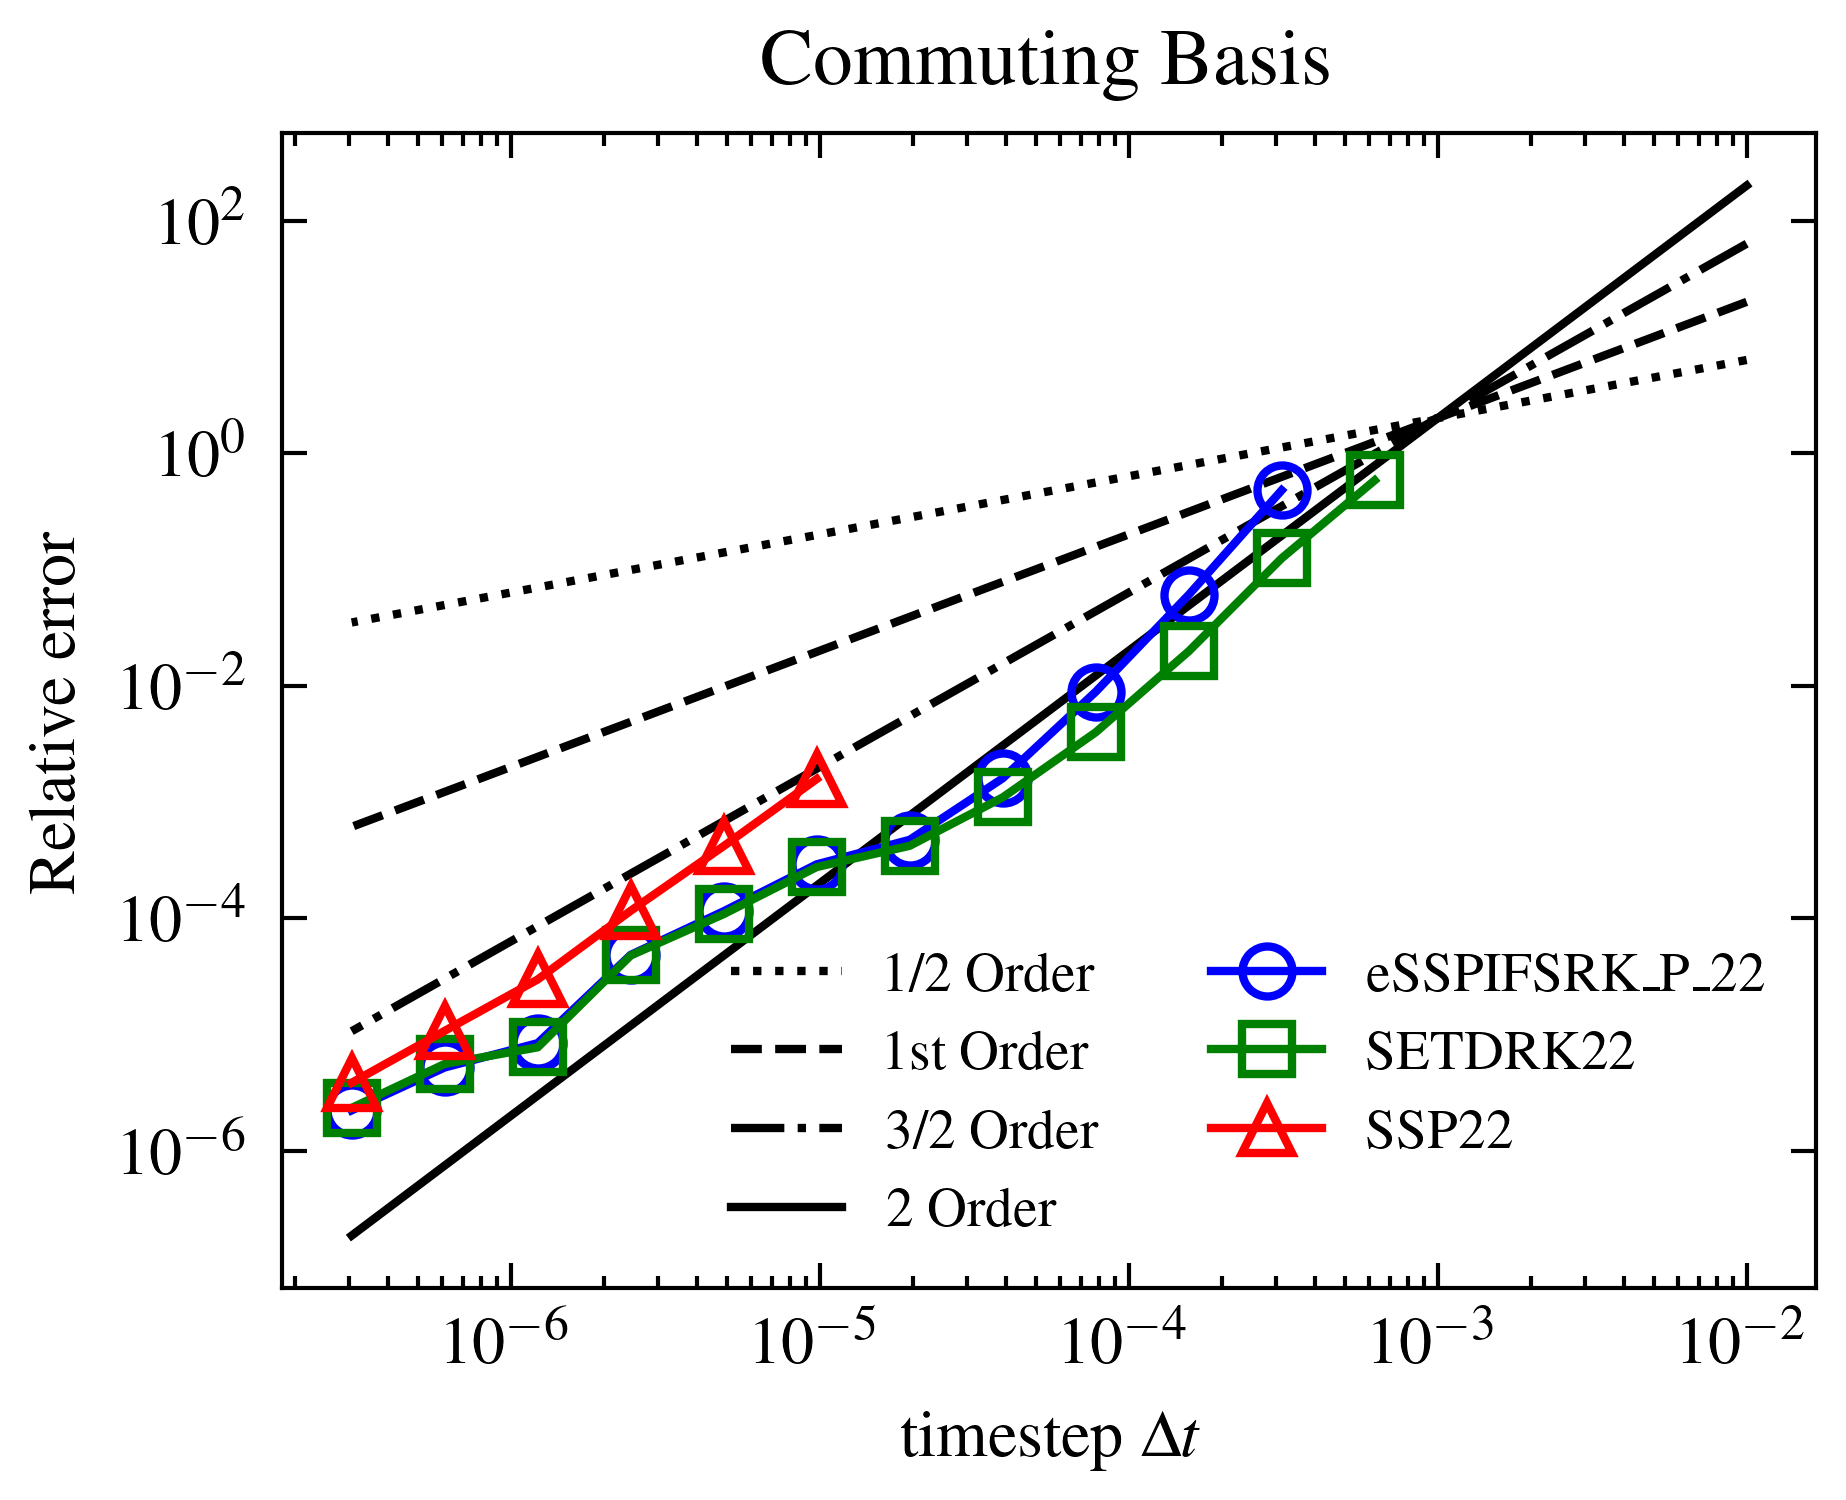

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
methods = ['Dealiased_eSSPIFSRK_P_22','Dealiased_SETDRK22','Dealiased_SSP22']

dt = 0.01*np.asarray([2**-i for i in range(0,max_number)])
values = array
print(values)
print(values.shape)
values = array
print(values,values.shape)
a = 1e-3#
v= 2#
plt.figure()
#plt.scatter(a,0.1, color='r', label='point')
# Mask values greater than 1 before plotting
values = np.where(values > 1, np.nan, values)
plt.loglog(dt,(dt**0.5)/a**0.5*v, linestyle=':', color='k', label=r'1/2 Order')
plt.loglog(dt,dt/a*v, linestyle='--', color='k', label='1st Order')
plt.loglog(dt,(dt**1.5)/a**1.5*v, linestyle='-.', color='k', label='3/2 Order')
plt.loglog(dt,dt**2/a**2*v, linestyle='-', color='k', label='2 Order')

marker_list = ['o', 's', '^', 'D', 'v', 'x', '+', '*', 'p', 'H', 'd', 'X']
color_list = ['b', 'g', 'r', 'c', 'm', 'y']
# In matplotlib, the marker for an upward-pointing triangle is '^'
for j, method in enumerate(methods):
    marker = marker_list[j % len(marker_list)]
    color = color_list[j % len(color_list)]
    plt.loglog(dt, values[j, :], marker=marker,color=color, linestyle='-', label=f'{method.replace("Dealiased_", "")}', markerfacecolor='none')

plt.xlabel(r'timestep $\Delta t$')
plt.ylabel('Relative error')
plt.title('Commuting Basis')

#plt.grid(True, which="both", ls="--")
plt.legend()
plt.legend(fontsize='small', loc='best', ncol=2)
#plt.grid(True, which="both", ls="--")

plt.savefig('../Saving/Example_5_G_COM_TC/EX5_G_COM_Temporal_convergence_SSP22_ETDRK22_eSSPIFSRK_P_22.png',bbox_inches='tight',dpi=300)
plt.show()


[[           nan            nan            nan            nan
             nan 4.79344982e-01 6.04380330e-02 8.85795829e-03
  1.59626287e-03 4.72111584e-04 2.90569605e-04 1.14788470e-04
  4.83586242e-05 8.41909272e-06 5.19910158e-06 2.22426683e-06]
 [           nan            nan            nan            nan
  5.83347836e-01 1.24631771e-01 1.97500593e-02 3.96745929e-03
  1.09323040e-03 4.19309204e-04 2.75302169e-04 1.08401587e-04
  4.77918435e-05 7.74551595e-06 5.57701648e-06 2.33579013e-06]
 [           nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan 1.57371579e-03 4.16868520e-04
  1.15775776e-04 2.97112950e-05 1.07395276e-05 3.84095699e-06]]
(3, 16)
[[           nan            nan            nan            nan
             nan 4.79344982e-01 6.04380330e-02 8.85795829e-03
  1.59626287e-03 4.72111584e-04 2.90569605e-04 1.14788470e-04
  4.83586242e-05 8.41909272e-06 5.19910158e-06 2.22426683e

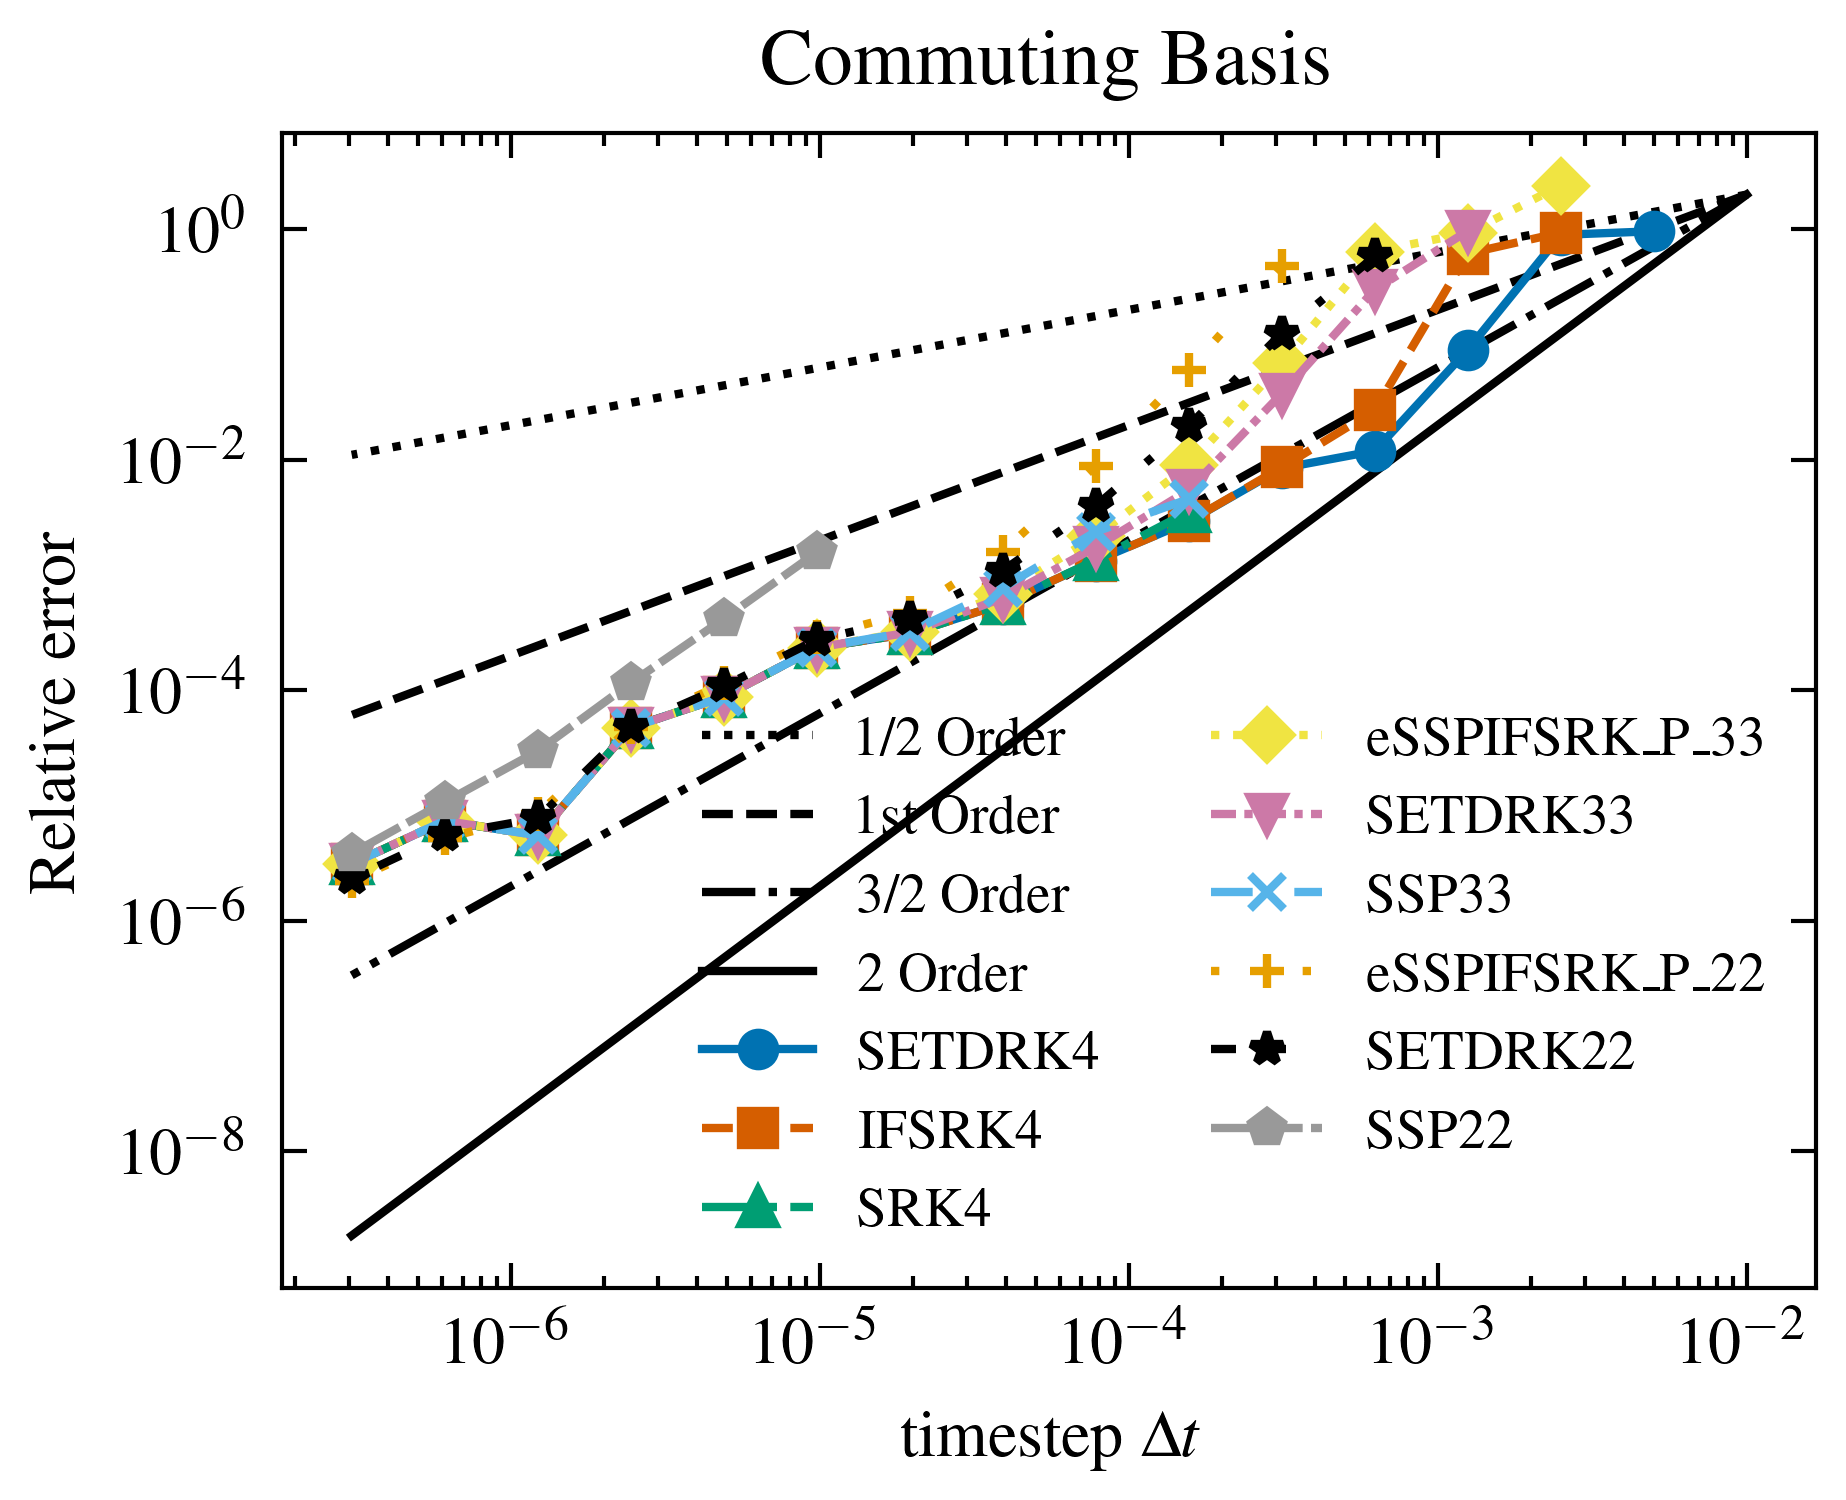

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
all_methods = ['Dealiased_SETDRK4','Dealiased_IFSRK4','Dealiased_SRK4',
           'Dealiased_eSSPIFSRK_P_33','Dealiased_SETDRK33','Dealiased_SSP33',
           'Dealiased_eSSPIFSRK_P_22','Dealiased_SETDRK22','Dealiased_SSP22']
max_number = 16
dt = 0.01*np.asarray([2**-i for i in range(0,max_number)])
values = array
print(values)
print(values.shape)
values = array
print(values,values.shape)
a = 1e-2#
v= 2#
plt.figure()
#plt.scatter(a,0.1, color='r', label='point')
# Mask values greater than 1 before plotting
values = np.where(values > 1, np.nan, values)
plt.loglog(dt,(dt**0.5)/a**0.5*v, linestyle=':', color='k', label=r'1/2 Order')
plt.loglog(dt,dt/a*v, linestyle='--', color='k', label='1st Order')
plt.loglog(dt,(dt**1.5)/a**1.5*v, linestyle='-.', color='k', label='3/2 Order')
plt.loglog(dt,dt**2/a**2*v, linestyle='-', color='k', label='2 Order')

marker_list = ['o', 's', '^', 'D', 'v', 'x', '+', '*', 'p']
# Use a colorblind-friendly palette for better accessibility
color_list = [
    "#0072B2",  # Blue
    "#D55E00",  # Vermillion
    "#009E73",  # Green
    "#F0E442",  # Yellow
    "#CC79A7",  # Purple
    "#56B4E9",  # Sky Blue
    "#E69F00",  # Orange
    "#000000",  # Black
    "#999999"   # Grey
]
#color_list = ["#0d23e8", "#32e80d", "#e81c0d", "#0da6e8", "#c4e80d", "#e85a0d",  "#24a3a5", "#98a524", "#a0792c"]
linestyle_list = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 5)), (0, (1, 10)), (0, (3, 5, 1, 5)), (0, (5, 1))]
# In matplotlib, the marker for an upward-pointing triangle is '^'
for j, method in enumerate(all_methods):
    print(j, method)
    marker = marker_list[j % len(marker_list)]
    color = color_list[j % len(color_list)]
    linestyle = linestyle_list[j % len(linestyle_list)]
    plt.loglog(dt, total_array[j, :], marker=marker, color=color, linestyle=linestyle, label=f'{method.replace("Dealiased_", "")}',  markersize=4)
    #plt.loglog(dt, total_array[j, :], marker=marker,color=color, linestyle=linestyle, label=f'{method.replace("Dealiased_", "")}')

plt.xlabel(r'timestep $\Delta t$')
plt.ylabel('Relative error')
plt.title('Commuting Basis')

#plt.grid(True, which="both", ls="--")
plt.legend()
plt.legend(fontsize='small', loc='best', ncol=2)
#plt.grid(True, which="both", ls="--")

plt.savefig('../Saving/Example_5_G_COM_TC/EX5_G_COM_Temporal_convergence_Allatty_C.png',bbox_inches='tight',dpi=300)
plt.show()

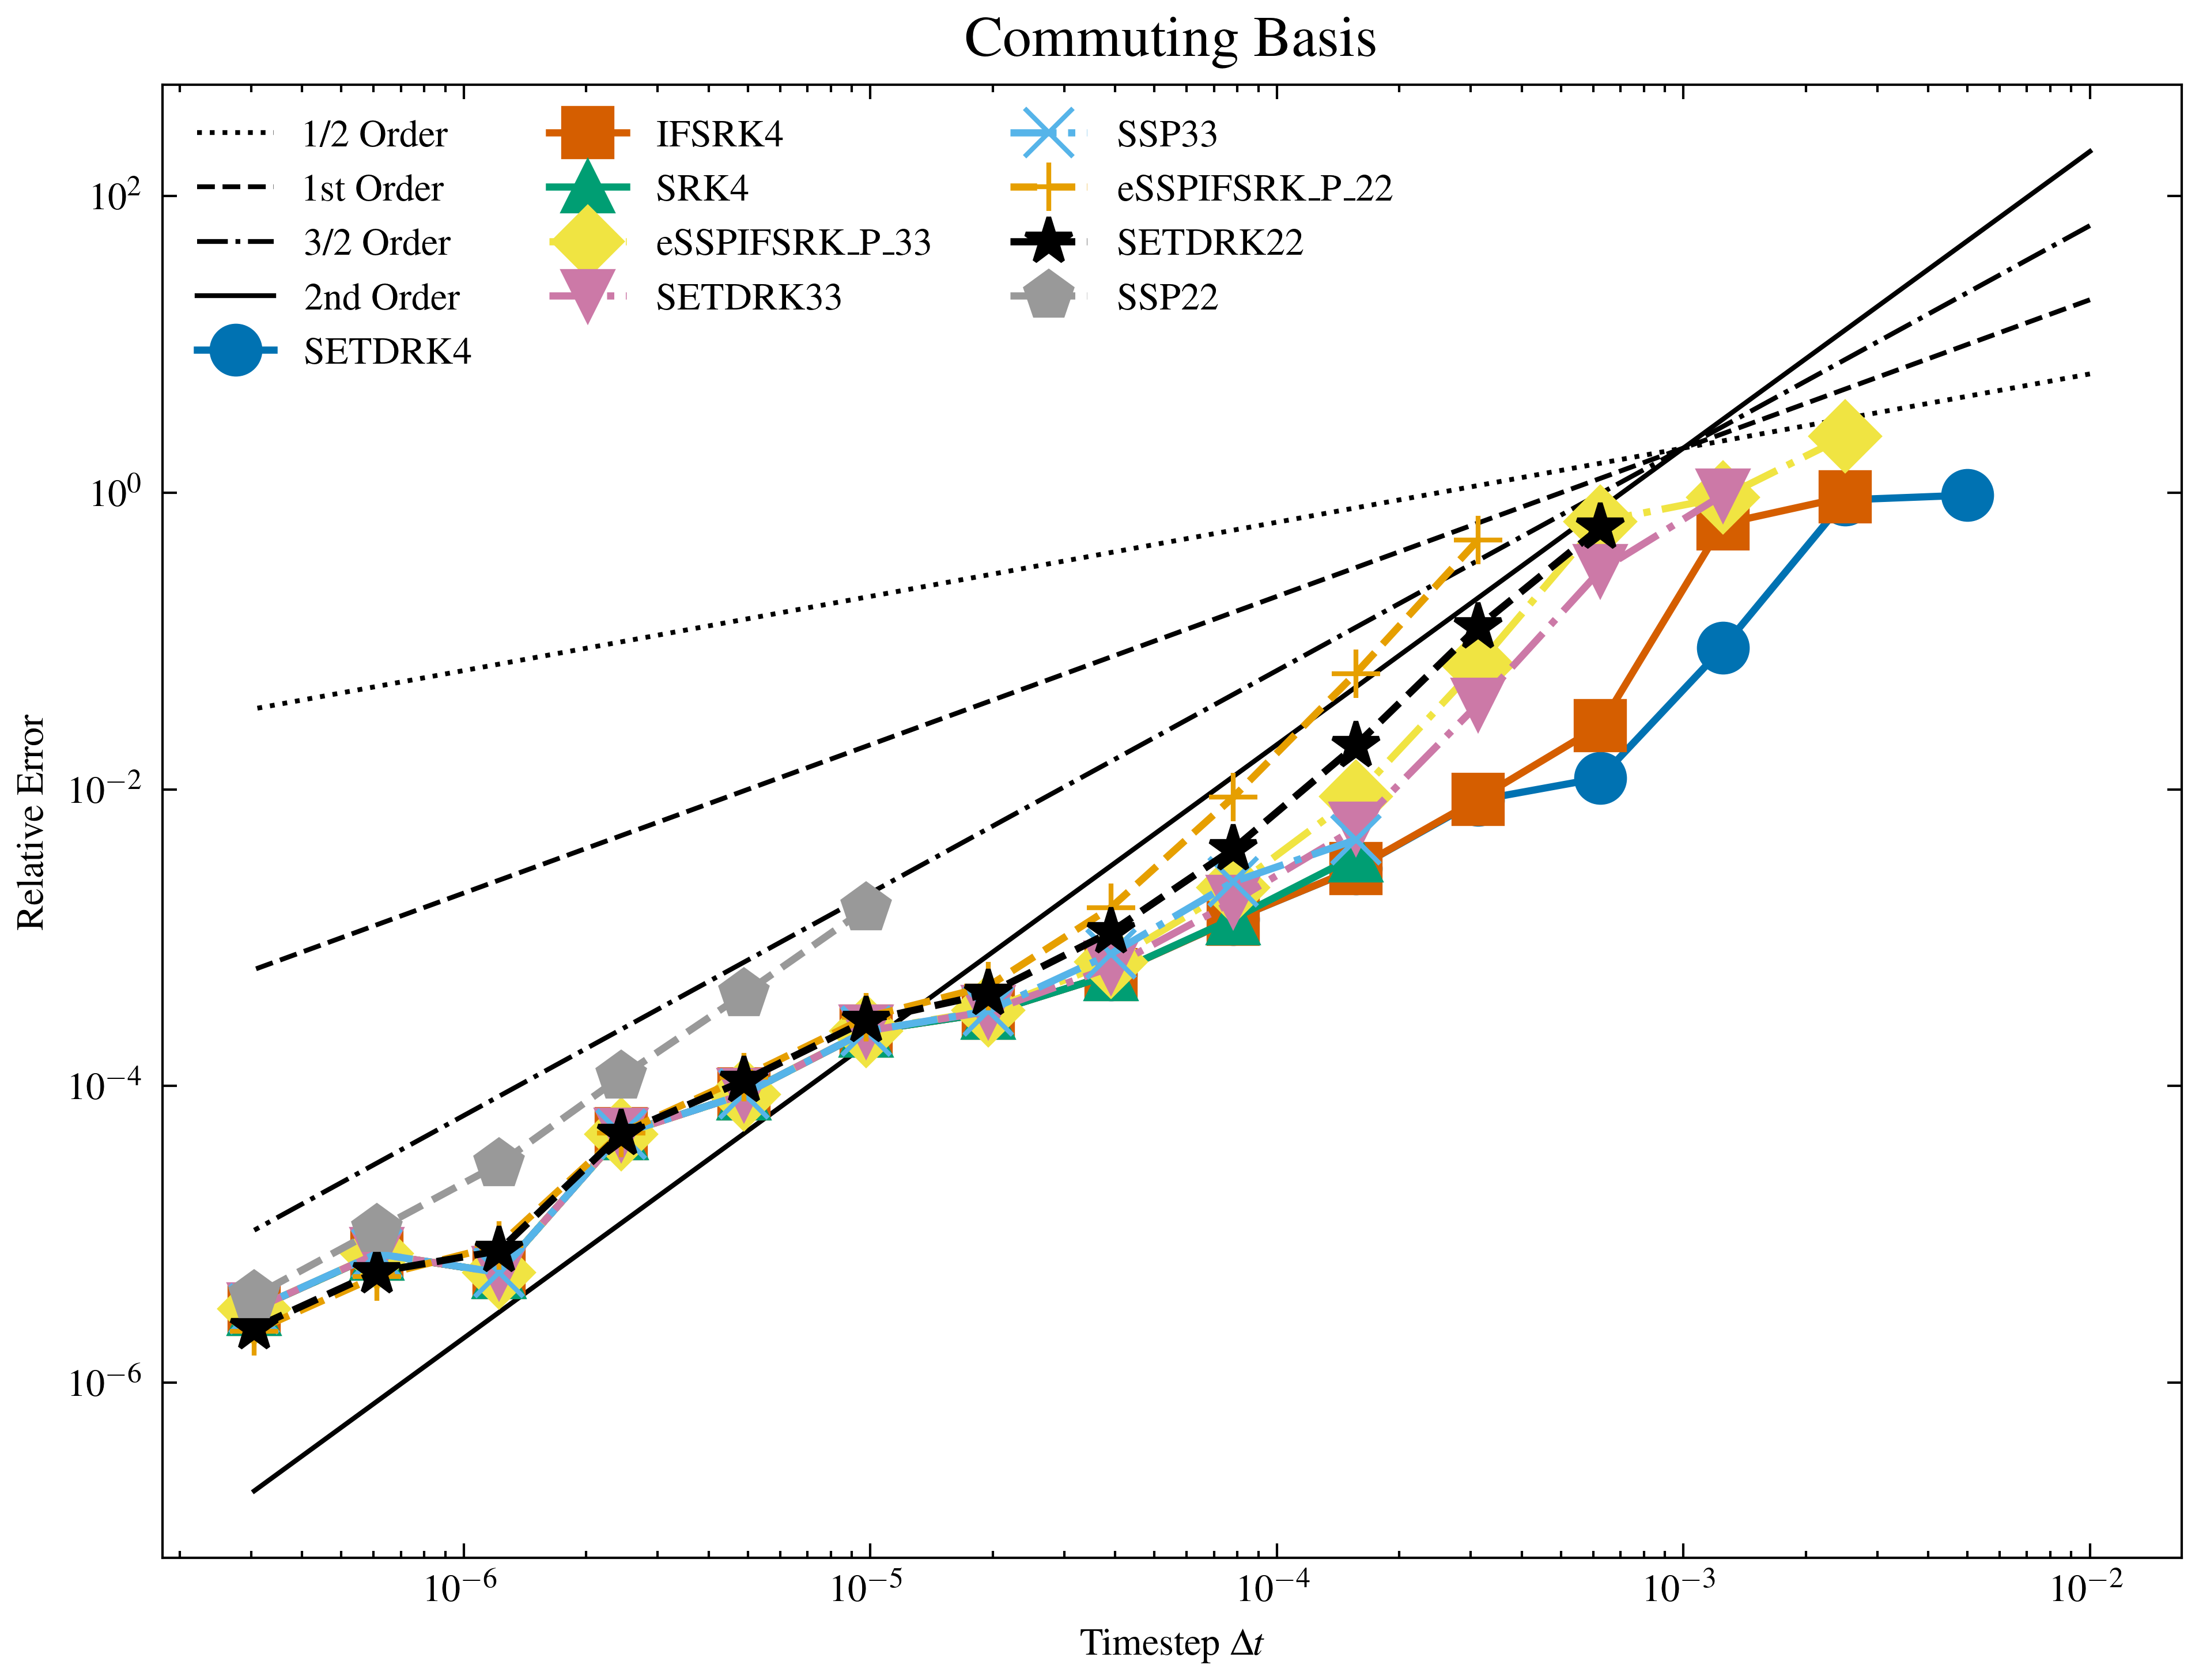

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'ieee'])

# --- Inputs ---
methods = [
    'Dealiased_SETDRK4','Dealiased_IFSRK4', 'Dealiased_SRK4',
    'Dealiased_eSSPIFSRK_P_33', 'Dealiased_SETDRK33', 'Dealiased_SSP33',
    'Dealiased_eSSPIFSRK_P_22', 'Dealiased_SETDRK22', 'Dealiased_SSP22'
]

max_number = 16
dt = 0.01 * np.asarray([2**-i for i in range(max_number)])

# Replace this with your actual data (assumed shape [9, max_number])
# Example placeholder (remove once array is loaded):
# total_array = np.random.rand(len(methods), max_number) * (dt**2)[None, :]
# Ensure values and total_array are defined
values = total_array  # If 'array' is the same as 'total_array'

# --- Plot Setup ---
fig, ax = plt.subplots(figsize=(6.5, 5))  # Slightly wider

# Reference lines for convergence order
a = 1e-3
v = 2
order_styles = {
    r'1/2 Order': (dt**0.5)/(a**0.5)*v,
    r'1st Order': dt/a*v,
    r'3/2 Order': (dt**1.5)/(a**1.5)*v,
    r'2nd Order': (dt**2)/(a**2)*v
}
order_linestyles = [':', '--', '-.', '-']
order_colors = ['k']*4
for (label, values), ls, color in zip(order_styles.items(), order_linestyles, order_colors):
    ax.loglog(dt, values, linestyle=ls, color=color, linewidth=1, alpha=1, label=label)

# Markers, colors, and linestyles
marker_list = ['o', 's', '^', 'D', 'v', 'x', '+', '*', 'p']
color_list = [
    "#0072B2", "#D55E00", "#009E73", "#F0E442",
    "#CC79A7", "#56B4E9", "#E69F00", "#000000", "#999999"
]
linestyle_list = ['-', '-', '-', '-.','-.','-.', '--', '--', '--']

# Plot each method
for j, method in enumerate(methods):
    label = method.replace("Dealiased_", "")
    marker = marker_list[j % len(marker_list)]
    color = color_list[j % len(color_list)]
    linestyle = linestyle_list[j % len(linestyle_list)]
    ax.loglog(dt, total_array[j, :], marker=marker, linestyle=linestyle,
              color=color, label=label, markersize=10, linewidth=1.5)

# --- Labels, Legend, Title ---
ax.set_xlabel(r'Timestep $\Delta t$')
ax.set_ylabel('Relative Error')
ax.set_title('Commuting Basis', fontsize=12)

# Combine and organize legend
ax.legend(fontsize='medium', loc='best', ncol=3, frameon=False)

# Tight layout and save
plt.tight_layout()
plt.savefig('../Saving/Example_5_G_COM_TC/EX5_G_COM_Temporal_convergence_Allatty.pdf', bbox_inches='tight',dpi=300)  # Vector version
plt.savefig('../Saving/Example_5_G_COM_TC/EX5_G_COM_Temporal_convergence_Allatty.png', bbox_inches='tight', dpi=300)

plt.show()